# Blood Cell Images Classification With Xception

Transfer learning is very popular. It is the easiest method to get very high accuracy with very low tuning. Transfer learning means that we use a pretrained model (to be exact, the Feature Extraction Layer) and we define the last Fully Connected Layer. The problem is, those models is resource intensive. Some of the pretrained model even uses more than 16GB of memory, meaning that we need a very expensive GPU if we want to use GPU for faster training.<br><br>
In this example, we chose Xception because it's the best good model that fits into the 16GB Memory of GPU. even with Kaggle free GPU, it still takes about three minutes to finish one epoch.

In [1]:
!cd '../input/blood-cells/dataset2-master/dataset2-master/images' && ls

TEST  TEST_SIMPLE  TRAIN


# Importing data & preprocessing.

Preprocessing step is for resizing and normalizing images, becuase the images we got has already been augmented.

In [2]:
#importing
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm

#define function to get the data
def get_data(folder):
    X = [] #X  contains all the images
    y = [] #y contains wbcTypes (neutrophil, eosinophil, monocyte, lymphocyte)

    for wbcType in os.listdir(folder):
        if not wbcType.startswith('.'):
            if wbcType in ['NEUTROPHIL']:
                label = 0 #neutrophil
            elif wbcType in ['EOSINOPHIL']:
                label = 1 #eosinophil
            elif wbcType in ['MONOCYTE']:
                label = 2  #monocyte
            elif wbcType in ['LYMPHOCYTE']:
                label = 3 #lymphocyte         

            #access image
            for filename in tqdm(os.listdir(folder + wbcType)):
                img_file = cv2.imread(folder + wbcType + '/' + filename)
                #resize to save memory
                img_file = cv2.resize(img_file, (224,224))
                
                #normalize images
                img_file = cv2.normalize(img_file, None, 0, 255, cv2.NORM_MINMAX)
                #img as array
                if img_file is not None:
                    img_arr = np.asarray(img_file)

                    #add to list
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [4]:
X_train, y_train = get_data('../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('../input/blood-cells/dataset2-master/dataset2-master/images/TEST/')

100%|██████████| 620/620 [00:02<00:00, 230.62it/s]


In [5]:
from keras.utils.np_utils import to_categorical

#encode  to hot vector, just like one host encoder
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

Using TensorFlow backend.


In [6]:
#print all the shapes
print('X_train shape = ',X_train.shape)
print('X_test shape = ',X_test.shape)
print('y_train shape = ',y_trainHot.shape)
print('y_test shape = ',y_testHot.shape)

X_train shape =  (9957, 224, 224, 3)
X_test shape =  (2487, 224, 224, 3)
y_train shape =  (9957, 4)
y_test shape =  (2487, 4)


## Building the Model

In [7]:
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import applications
from keras.optimizers import Adam

In [8]:
base_model=applications.Xception(input_shape=(224,224,3), weights='imagenet',include_top=False) 

x = base_model.output
x = Flatten()(x)
x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
y = Dense(4,activation='softmax')(x)

83689472/83683744 [==============================] - 2s 0us/step


Adam is a very popular and widely used optimizer.<br>
categorical_crossentropy is used because this is a four class data.

In [9]:
input = base_model.input
model = Model(input, y)
model.compile(loss='categorical_crossentropy',
          optimizer=Adam(),
          metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

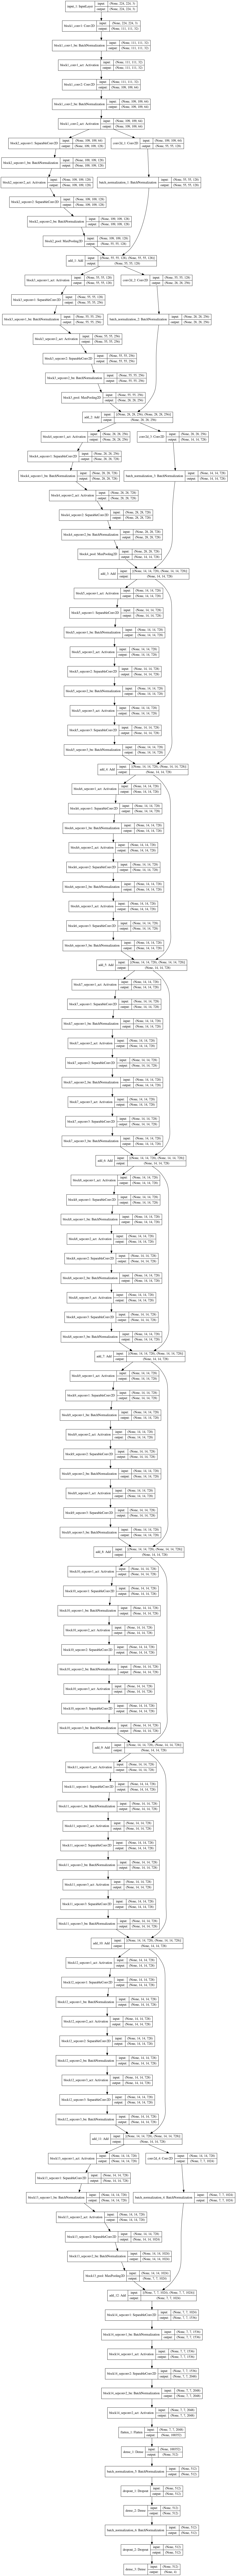

In [10]:
from keras.utils.vis_utils import plot_model

#plotting the model
plot_model(model, show_shapes=True, to_file="newModel.png")

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#training the model

#for every epoch, if the val_accuracy is better than the previous one, the network will be saved
checkpoint = ModelCheckpoint("newModel.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#jika val_accuracy sudah convergence sebanyak 20x, maka porses training model akan dihentikan.
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='max') 
#callback
callbacks_list = [checkpoint, early]

#training the model
history = model.fit(X_train,
         y_trainHot,
         epochs = 50,
         batch_size = 64,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list)

#saving history to csv to plot later on
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Train on 9957 samples, validate on 2487 samples
Epoch 1/50
9957/9957 [==============================] - 201s 20ms/step - loss: 0.3363 - accuracy: 0.8718 - val_loss: 5.6386 - val_accuracy: 0.6265

Epoch 00001: val_accuracy improved from -inf to 0.62646, saving model to newModel.h5
Epoch 2/50
9957/9957 [==============================] - 182s 18ms/step - loss: 0.0754 - accuracy: 0.9750 - val_loss: 0.8119 - val_accuracy: 0.8770

Epoch 00002: val_accuracy improved from 0.62646 to 0.87696, saving model to newModel.h5
Epoch 3/50
9957/9957 [==============================] - 182s 18ms/step - loss: 0.0390 - accuracy: 0.9898 - val_loss: 1.3213 - val_accuracy: 0.8872

Epoch 00003: val_accuracy improved from 0.87696 to 0.88721, saving model to newModel.h5
Epoch 4/50
9957/9957 [==============================] - 182s 18ms/step - loss: 0.0254 - accuracy: 0.9939 - val_loss: 0.8968 - val_accuracy: 0.9263

Epoch 00004: val_accuracy improved from 0.88721 to 0.92632, saving model to newModel.h5
Epoch 5/50


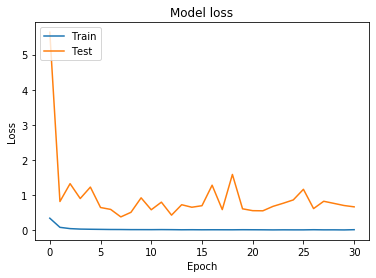

In [12]:
#plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

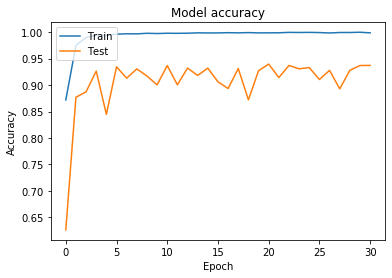

In [13]:
#plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# Evaluate the model
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_testHot, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
2487/2487 [==============================] - 11s 5ms/step
test loss, test acc: [0.6596098298575176, 0.93707275390625]


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred=model.predict(X_test)

#confusion matrix
print(confusion_matrix(y_testHot.argmax(axis=1), y_pred.argmax(axis=1)))
print('\n\n')

#classification report
print(classification_report(y_testHot.argmax(axis=1), y_pred.argmax(axis=1)))

[[548  66   0  10]
 [ 72 550   0   1]
 [151   4 465   0]
 [  9   0   0 611]]



              precision    recall  f1-score   support

           0       0.70      0.88      0.78       624
           1       0.89      0.88      0.88       623
           2       1.00      0.75      0.86       620
           3       0.98      0.99      0.98       620

    accuracy                           0.87      2487
   macro avg       0.89      0.87      0.88      2487
weighted avg       0.89      0.87      0.88      2487



The val_accuracy is already good as it is above 90%.<br>

# Reference

<b>Blog</b><br>

Importing data to List<br>
https://www.kaggle.com/paultimothymooney/identify-blood-cell-subtypes-from-images<br>

Deep Learning For Beginners Using Transfer Learning In Keras<br>
https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e<br>

Review: Xception — With Depthwise Separable Convolution, Better Than Inception-v3 (Image Classification)<br>
https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568<br>

Common Loss functions in machine learning<br>
https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23<br>

Adam — latest trends in deep learning optimization.<br>
https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c<br>

<br><b>Documentation</b><br>

Keras Applications<br>
https://keras.io/api/applications<br>

Optimizers<br>
https://keras.io/optimizers/<br>

Metrics<br>
https://keras.io/api/metrics/<br>

sklearn.metrics.confusion_matrix<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html<br>

sklearn.metrics.classification_report<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html